In [1]:
import numpy as np
import os
from os.path import join, isdir, getsize, exists
# from nltk.stem.snowball import SnowballStemmer
import json
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib notebook

# Load and proprocess documents
**Load document labels**

In [2]:
segmented_path = u'./corpus/segmented-docs' # it will listdir into unicode
doc_labels = [fn for fn in os.listdir(segmented_path) if isdir(join(segmented_path, fn))] # list only folders
doc_labels_idx = {}
n_labels = len(doc_labels)
for i, label in enumerate(doc_labels):
    print i, label
    doc_labels_idx[label] = i
print 'Total Labels:', n_labels

0 บริหารธุรกิจ
1 ประมง
2 มนุษยศาสตร์
3 วนศาสตร์
4 วิทยาการจัดการ
5 วิทยาศาสตร์
6 วิทยาศาสตร์การกีฬา
7 วิศวกรรมศาสตร์
8 ศิลปศาสตร์และวิทยาศาสตร์
9 ศึกษาศาสตร์
10 ศึกษาศาสตร์และพัฒนศาสตร์
11 สถาปัตยกรรมศาสตร์
12 สังคมศาสตร์
13 สัตวแพทยศาสตร์
14 สิ่งแวดล้อม
15 อุตสาหกรรมเกษตร
16 เกษตร
17 เศรษฐศาสตร์
18 โครงการจัดตั้งวิทยาเขตสุพรรณบุรี
19 โครงการสหวิทยาการระดับบัณฑิตศึกษา
Total Labels: 20


** Load dataset **

In [3]:
%%time
dataset_contents, dataset_labels = [], []
for i, label in enumerate(doc_labels):
    curr_dir = join(segmented_path, label)
    fns = os.listdir(curr_dir)
    for fn in fns:
        file_path = join(curr_dir, fn)
        dataset_labels.append(i)
        with open(file_path, 'r') as f:
            content = unicode(f.read(), 'utf8')
            dataset_contents.append(content)
N = len(dataset_labels)
print 'Total Segmented Documents:', N

Total Segmented Documents: 2549
Wall time: 1.82 s


** Define a function that trims words then replace all PIPELINE by space **

In [4]:
def pretty_trim(text):
    words = text.split(u'|')
    stripped_words_generator = (word.strip() for word in words)
#     stemmed_words_generator = (stemmer.stem(word) for word in stripped_words_generator)
    trimmed_words = (word for word in stripped_words_generator if 1 < len(word)) # retains words that are not empty
    alpha_words = (word for word in trimmed_words if not word.isnumeric() or len(word) <= 4) # allow only <= 4-digit number
    return u' '.join(alpha_words)

**Show sample content**

In [8]:
print 'Content:', dataset_contents[1][:2**9], '...'
print 'Label:', dataset_labels[1]

Content: i|49737869| |i| |page| |I|วิทยานิพนธ์| |P|การ|วิเคราะห์|ต้นทุน|ต่อ|หน่วย|ผลผลิต| |ใน|การผลิต|บัณฑิต|ระดับ|ปริญญาตรี|ของ|วิทยาลัย|เอกชน| |จังหวัด|สุราษฎร์ธานี| |i| |analysi| |of| |cost| |per| |output| |unit| |in| |produc| |undergradu| |iof| |a| |privat| |colleg| |in| |surat| |thani| |prov| |inc| |I|นางสาว|กา|ญ|จน|ธัช| |บัว|พา| |I|บัณฑิต|วิทยาลัย| |มหาวิทยาลัยเกษตรศาสตร์| |I|พ| |ศ| |๒๕๕๔| |I|ใบรับรอง|วิทยานิพนธ์| |I|บัณฑิต|วิทยาลัย| |มหาวิทยาลัยเกษตรศาสตร์| |I|บัญชีมหาบัณฑิต| |I|ปริญญา| |I|บัญชี| |บัญชี| |I|ส ...
Label: 0


** Show sample content after pretty_trimmed() **

In [9]:
print 'Content:', pretty_trim(dataset_contents[1][:2**9]), '...'
print 'Label Str:', doc_labels[dataset_labels[1]]

Content: page วิทยานิพนธ์ การ วิเคราะห์ ต้นทุน ต่อ หน่วย ผลผลิต ใน การผลิต บัณฑิต ระดับ ปริญญาตรี ของ วิทยาลัย เอกชน จังหวัด สุราษฎร์ธานี analysi of cost per output unit in produc undergradu iof privat colleg in surat thani prov inc นางสาว กา จน ธัช บัว พา บัณฑิต วิทยาลัย มหาวิทยาลัยเกษตรศาสตร์ ๒๕๕๔ ใบรับรอง วิทยานิพนธ์ บัณฑิต วิทยาลัย มหาวิทยาลัยเกษตรศาสตร์ บัญชีมหาบัณฑิต ปริญญา บัญชี บัญชี ...
Label Str: บริหารธุรกิจ


## Trim or load all documents

In [5]:
%%time
fp = u'./corpus/dataset_contents_trimmed.json'
if exists(fp):
    print 'Loading trimmed documents ...'
    with open(fp, 'r') as f:
        dataset_contents_trimmed = json.load(f)
else:
    print 'Trimming documents ...'
    dataset_contents_trimmed = map(pretty_trim, dataset_contents)
    print 'Dumping ...'
    # dumb into a big file for later use because this list is very costful to compute
    with open(fp, 'w') as f:
        json.dump(dataset_contents_trimmed, f, ensure_ascii=True)
print 'Size in GB:', getsize(fp) / 1024.0 / 1024.0 / 1024.0

Loading trimmed documents ...
Size in GB: 1.74424816016
Wall time: 1min 3s


In [6]:
del dataset_contents

** Count number of words for each document **

In [12]:
%time dataset_words_count = np.array([len(content.split()) for content in dataset_contents_trimmed])
print 'Words Count Mean: ', np.mean(dataset_words_count)
dataset_words_count[:min(40,N)]

Wall time: 7.82 s
Words Count Mean:  33023.6178894


array([38309, 56784, 22738, 35910, 35363, 34419, 39693, 42282, 28067,
       42248, 34120, 41504, 24031, 29710, 30161, 42896, 36542, 34551,
       33115, 30222, 19691, 23651, 23042, 35982, 47927, 45929, 38292,
       24973, 35911, 36251, 48389, 58244, 33454, 41159, 65081, 44070,
       45534, 50889, 49022, 39028])

** Show words count histogram **

<IPython.core.display.Javascript object>


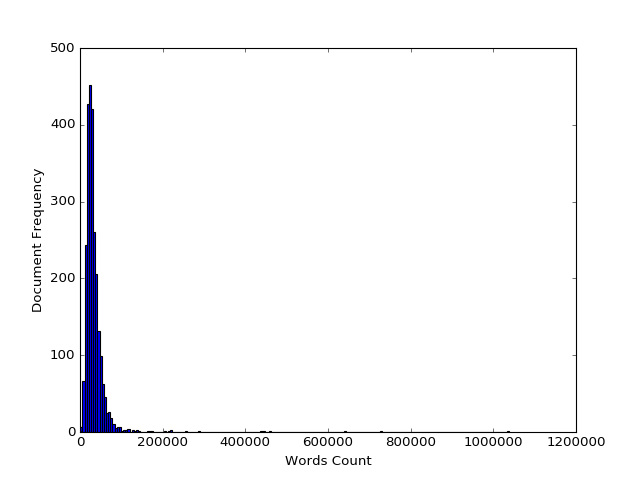

In [13]:
plt.figure()
plt.hist(dataset_words_count, bins=200)
plt.xlabel('Words Count')
plt.ylabel('Document Frequency')
plt.show()

# Machine Learning section

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
# from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
# from sklearn.neural_network import BernoulliRBM
from collections import Counter
from scipy.sparse import vstack

## Loading saved models
You can skip a lot of computation if you have previous models

In [308]:
%%time
filename = 'models_persistence/pickle_models'
if exists(filename):
    pretty_trim, counter, tfidf, rfe, clfs = joblib.load(filename)
    filename = 'models_persistence/final_dataset'
    X_train_final, y_train, X_test_final, y_test = joblib.load(filename)
else:
    print "The models don't exist"

Wall time: 5.4 s


## Train/Test Split
Split dataset into 2 parts and leave the test part untouched (not fitting it with any model)

Split using stratified sampling might be useful if you want to test all label including the skewed low frequency label

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dataset_contents_trimmed, np.array(dataset_labels),
                                                    test_size=0.2, stratify=dataset_labels, random_state=42)
print 'Train Size:', len(X_train)
print 'Test Size:', len(X_test)
train_counter, test_counter = Counter(y_train), Counter(y_test)
print 'Un-trained label:', list(set(xrange(n_labels)) - set(train_counter))
print 'Un-tested label:', list(set(xrange(n_labels)) - set(test_counter))

Train Size: 2039
Test Size: 510
Un-trained label: []
Un-tested label: []


### Plot bar chart of dataset frequency per label

<IPython.core.display.Javascript object>


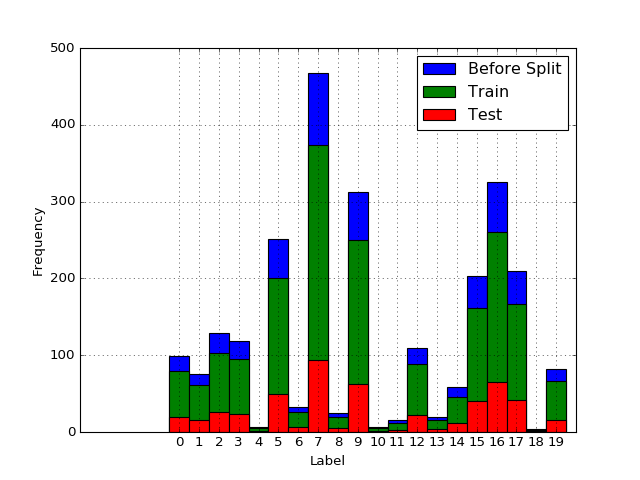

In [9]:
train_label_freqs = np.zeros(n_labels, np.int32)
test_label_freqs = np.zeros(n_labels, np.int32)
dataset_label_freqs = np.zeros(n_labels, np.int32)
for k,v in train_counter.iteritems():
    train_label_freqs[k] = v
for k,v in test_counter.iteritems():
    test_label_freqs[k] = v
for k,v in Counter(dataset_labels).iteritems():
    dataset_label_freqs[k] = v
plt.figure()
plt.bar(np.arange(n_labels)-0.5, dataset_label_freqs, 1, color='b')
plt.bar(np.arange(n_labels)-0.5, train_label_freqs, 1, color='g')
plt.bar(np.arange(n_labels)-0.5, test_label_freqs, 1, color='r')
plt.xticks(np.arange(len(doc_labels)))
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.legend(['Before Split','Train', 'Test'], loc='best')
plt.grid()
plt.show()

## Feature Extraction
### Bag of Words Representation
Initialize a vectorizer that counts word instances and apply Tfidf (Term-Frequency * Inverse-Document-Frequency) to them

In [20]:
## saving English stop words to disk
# from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
# stop_words = ENGLISH_STOP_WORDS
# fp = 'stop_words.txt'
# with open(fp, 'w') as f:
#     words = u'\n'.join(sorted(stop_words))
#     f.write(words.encode('utf-8'))
# print len(stop_words)

318


In [10]:
## reading stop words from disk
fp = 'stop_words_unique.txt'
with open(fp, 'r') as f:
    stop_words = unicode(f.read(), 'utf-8')
stop_words = stop_words.split(u'\n')
print 'Stop Words:', len(stop_words)

Stop Words: 928


In [11]:
%%time

def simple_split(string):
    return string.split()

print 'Vectorizing...'
counter = CountVectorizer(stop_words=stop_words, ngram_range=(1,2), max_features=250000,
                          tokenizer=simple_split, min_df=10, max_df=0.75)
%time X_train_count = counter.fit_transform(X_train)
%time X_test_count = counter.transform(X_test)

print 'Transforming Tf-Idf...'
tfidf = TfidfTransformer()
%time X_train_vectorized = tfidf.fit_transform(X_train_count)
%time X_test_vectorized = tfidf.transform(X_test_count)

Vectorizing...
Wall time: 4min 19s
Wall time: 36.3 s
Transforming Tf-Idf...
Wall time: 1.44 s
Wall time: 289 ms
Wall time: 4min 57s


** Save extracted feature names to disk **

In [12]:
%%time
feature_names = counter.get_feature_names()
fn = 'feature_names.txt'
with open(fn, 'w') as f:
    f.write(u'\n'.join(feature_names).encode('utf8'))
print 'Check file %s to see all extracted feature names' % fn
print 'Total names:', len(feature_names)

Check file feature_names.txt to see all extracted feature names
Total names: 250000
Wall time: 870 ms


**Vectorized Dataset Statistics**

In [13]:
print 'Train Shape:', X_train_vectorized.shape
print 'Sample content of type %s:' % type(X_train_vectorized)
print X_train_vectorized

Train Shape: (2039, 250000)
Sample content of type <class 'scipy.sparse.csr.csr_matrix'>:
  (0, 109969)	0.00053260471086
  (0, 101898)	0.000680753782631
  (0, 81296)	0.000696863705211
  (0, 104738)	0.000649643778282
  (0, 115765)	0.000708874963301
  (0, 173957)	0.000745129470713
  (0, 79095)	0.000560337531208
  (0, 150462)	0.000446817866231
  (0, 96089)	0.00048734474295
  (0, 181348)	0.000413149553322
  (0, 147689)	0.000618410764821
  (0, 221713)	0.000543995165602
  (0, 38106)	0.000583702569138
  (0, 60701)	0.000773250651383
  (0, 165056)	0.000708874963301
  (0, 217462)	0.000708874963301
  (0, 81714)	0.000615373923301
  (0, 120763)	0.000513846764412
  (0, 122523)	0.000773250651383
  (0, 92712)	0.000537360853601
  (0, 81924)	0.000341510316886
  (0, 181305)	0.000526530145828
  (0, 81785)	0.00037187119659
  (0, 120764)	0.000378106813177
  (0, 219885)	0.000550998235218
  :	:
  (2038, 213741)	0.00102816169903
  (2038, 99812)	0.00374872992276
  (2038, 91724)	0.00340601974642
  (2038, 156331)

## Feature Selection

Recursive feature elimination using weights of the chosen learning algorithm

In [14]:
%%time
rfe = RFE(SGDClassifier(loss='hinge', n_iter=7), n_features_to_select=20000, step=0.15, verbose=1)
X_train_selected = rfe.fit_transform(X_train_vectorized, y_train)
X_test_selected = rfe.transform(X_test_vectorized)
print X_train_selected.shape, X_test_selected.shape

Fitting estimator with 250000 features.
Fitting estimator with 212500 features.
Fitting estimator with 175000 features.
Fitting estimator with 137500 features.
Fitting estimator with 100000 features.
Fitting estimator with 62500 features.
Fitting estimator with 25000 features.
(2039, 20000) (510, 20000)
Wall time: 30.1 s


** Save top feature names to file **

In [15]:
%%time
top_features = np.array([feature for feature, support in zip(feature_names, rfe.support_) if support])
file_name = 'feature_names_top.txt'
with open(file_name, 'w') as f:
    f.write(u'\n'.join(top_features).encode('utf8'))
print 'Go check file %s' % file_name

Go check file feature_names_top.txt
Wall time: 328 ms


** Save word count to disk **

In [16]:
%%time
X_train_count_support = X_train_count[:,rfe.support_].T
m, n = X_train_count_support.shape[0], len(doc_labels)
freqs = np.empty((m, n), np.int32)

for label in xrange(n):
    freqs[:,label] = X_train_count_support[:,y_train==label].sum(axis=1).flatten()

with open('word_count_per_label.txt', 'w') as f:
    for i in xrange(m):
        line = []
        for j in xrange(n):
            line.append(str(freqs[i,j]))
        f.write('\t'.join(line) + '\n')

print freqs.shape

(20000L, 20L)
Wall time: 957 ms


## Dimensionality Reduction

#### Unsupervised non-linear dimension reduction

Pre-training with Bernoulli Restricted Boltzmann Machine

In [136]:
# %%time
# rbm = BernoulliRBM(n_components=50, learning_rate=0.2, batch_size=20, n_iter=20, random_state=42, verbose=1)
# X_train_rbm = rbm.fit_transform(X_train_selected)
# X_test_rbm = rbm.transform(X_test_selected)
# print X_train_rbm.shape

In [137]:
# print rbm.components_.shape
# print rbm.components_ # weight of each edge, components_[i,j] = weight of edge from hidden node i to visible node j

Truncated SVD (Single Value Decomposition) is called Latent Semantic Analysis (LSA) in text analysis context

In [345]:
# %%time
# svd = TruncatedSVD(n_components=200) # works on sparse data
# X_train_reduced = svd.fit_transform(X_train_selected)
# X_test_reduced = svd.transform(X_test_selected)
# print 'Train Shape:', X_train_reduced.shape
# print 'Explained Variance Ratio Sum:', svd.explained_variance_ratio_.sum()
# print 'Top 5 Explained Variance Ratio:', svd.explained_variance_ratio_[:5]

Train Shape: (620L, 200L)
Explained Variance Ratio Sum: 0.680931519226
Top 5 Explained Variance Ratio: [ 0.08757407  0.0295904   0.01745794  0.01065465  0.01066833]
Wall time: 1.93 s


## Training models

In [17]:
X_train_final, X_test_final = X_train_selected, X_test_selected

In [18]:
%%time
models = [
#     SGDClassifier(n_iter=20),
#     DecisionTreeClassifier(max_depth=20, min_samples_split=5, min_samples_leaf=3),
#     AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42),
    RandomForestClassifier(max_depth=None, min_samples_split=1, max_features=1000,
                           n_estimators=100, random_state=42),
#     ExtraTreesClassifier(max_depth=None, min_samples_split=1, max_features=1000,
#                          n_estimators=100, random_state=42)
]
for clf in models:
    print 'Training', type(clf).__name__
    %time clf.fit(X_train_final, y_train)

Training RandomForestClassifier
Wall time: 36.5 s
Wall time: 36.5 s


## Models Scoring
Evaluate on both train and test set

In [19]:
# define decision tree evaluator
def write_dt_features(dt, filename='feature_names_decision-tree.txt'):
    im = dt.feature_importances_
    f = open(filename, 'w')
    indices = np.argsort(im)[::-1]
    for i, idx in enumerate(indices):
        name, val = top_features[idx], im[idx]
        if not val: break
        f.write((name + '\t' + str(val) + '\n').encode('utf8'))
    f.close()
    print 'Total important features:', i

In [20]:
write_dt_features(models[0])

Total important features: 8496


In [21]:
for clf in models:
    print type(clf).__name__
    for X,y,t in [(X_train_final, y_train, 'Train'), (X_test_final, y_test, 'Test')]:
        pred = clf.predict(X)
        print '=>', t, 'dataset'
        print 'Accuracy, f1-weighted, f1-macro, f1-micro score:\n', \
        np.around(accuracy_score(y, pred), 3), \
        np.around(f1_score(y, pred, average='weighted'), 3), \
        np.around(f1_score(y, pred, average='macro'), 3), \
        np.around(f1_score(y, pred, average='micro'), 3)
    print

RandomForestClassifier
=> Train dataset
Accuracy, f1-weighted, f1-macro, f1-micro score:
1.0 1.0 1.0 1.0
=> Test dataset
Accuracy, f1-weighted, f1-macro, f1-micro score:
0.916 0.904 0.676 0.916



C:\Users\off99555\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Train a Model with Cross-Validation Set

Tune the model's hyper-parameters to give high K-Fold CV score

In [251]:
# params = {'loss':['hinge'], 'alpha':[5e-4, 1e-4, 5e-5], 'n_iter':[35]}
# gs1 = GridSearchCV(SGDClassifier(random_state=42), params, scoring='f1_weighted', cv=3, verbose=3)

In [252]:
# params = {'criterion':['gini'], 'max_depth':[15, 20, 25], 'min_samples_split':[1, 5], 'min_samples_leaf':[1,3]}
# gs2 = GridSearchCV(DecisionTreeClassifier(random_state=42), params, scoring='f1_weighted', cv=3, verbose=3)

In [22]:
params = {'max_features':['log2', 'sqrt', 1000, 2000, 3000]}
gs3 = GridSearchCV(
    RandomForestClassifier(max_depth=None, min_samples_split=1, max_features=None,
                           n_estimators=100, random_state=42), params, scoring='f1_weighted', cv=2, verbose=3)

In [23]:
gs_list = [gs3]
clfs = []
for gs in gs_list:
    print 'Training', type(gs.estimator).__name__
    %time gs.fit(X_train_final, y_train)
    print gs.best_estimator_
    clfs.append(gs.best_estimator_)
    print 'Best Hyper-parameters:', gs.best_params_
    print 'Best Score:', gs.best_score_

Training RandomForestClassifier
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] max_features=log2 ...............................................
[CV] ...................... max_features=log2, score=0.657333 -   1.6s
[CV] max_features=log2 ...............................................
[CV] ...................... max_features=log2, score=0.684303 -   1.5s
[CV] max_features=sqrt ...............................................
[CV] ...................... max_features=sqrt, score=0.788976 -   4.3s
[CV] max_features=sqrt ...............................................
[CV] ...................... max_features=sqrt, score=0.782879 -   4.4s
[CV] max_features=1000 ...............................................
[CV] ...................... max_features=1000, score=0.872686 -  15.8s
[CV] max_features=1000 ...............................................
[CV] ...................... max_features=1000, score=0.864264 -  15.7s
[CV] max_features=2000 .................................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.1min finished


Wall time: 4min 26s
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2000, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Best Hyper-parameters: {'max_features': 2000}
Best Score: 0.887825014305


** Save models' state to disk **

In [24]:
%%time

# # SVM
# coef = clfs[0].coef_.T
# m, n = coef.shape
# with open('coef.txt', 'w') as f:
#     for i in xrange(m):
#         line = []
#         for j in xrange(n):
#             line.append(str(coef[i,j]))
#         f.write('\t'.join(line) + '\n')

# print m, n

# decision tree
write_dt_features(clfs[0])

Total important features: 7682
Wall time: 87 ms


In [25]:
for clf in clfs:
    print type(clf).__name__
    for X,y,t in [(X_train_final, y_train, 'Train'), (X_test_final, y_test, 'Test')]:
        pred = clf.predict(X)
        print '=>', t, 'dataset'
        print 'Accuracy, f1-weighted, f1-macro, f1-micro score:\n', \
        np.around(accuracy_score(y, pred), 3), \
        np.around(f1_score(y, pred, average='weighted'), 3), \
        np.around(f1_score(y, pred, average='macro'), 3), \
        np.around(f1_score(y, pred, average='micro'), 3)
        print
print 'Baseline score by chance:', 1.0 / n_labels, '(assume that an algorithm randomly guesses the label)'

RandomForestClassifier
=> Train dataset
Accuracy, f1-weighted, f1-macro, f1-micro score:
1.0 1.0 1.0 1.0

=> Test dataset
Accuracy, f1-weighted, f1-macro, f1-micro score:
0.927 0.917 0.699 0.927

Baseline score by chance: 0.05 (assume that an algorithm randomly guesses the label)


## Model Evaluation Metrics
Visualize confusion matrix and show classification report

In [26]:
y_true = y_test
y_preds = []
for clf in clfs:
    y_preds.append(clf.predict(X_test_final))

### Confusion Matrix
Visualize true positives and false positives

In [27]:
def plot_confusion_matrix(cm, title='Confusion matrix', model_name='Model', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title + ' (%s)' % model_name)
    plt.colorbar()
    tick_marks = np.arange(n_labels)
    plt.xticks(tick_marks, rotation=0)
    plt.yticks(tick_marks)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[18  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 46  0  0  0  0  0  0  0  0  0  0  3  0  0  1]
 [ 0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 94  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  1  0  0  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 62  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  1  0  0  0]
 [ 0  0  0  0  0  3  0  1  0  0  0  0  0  0  0 35  2  0

<IPython.core.display.Javascript object>


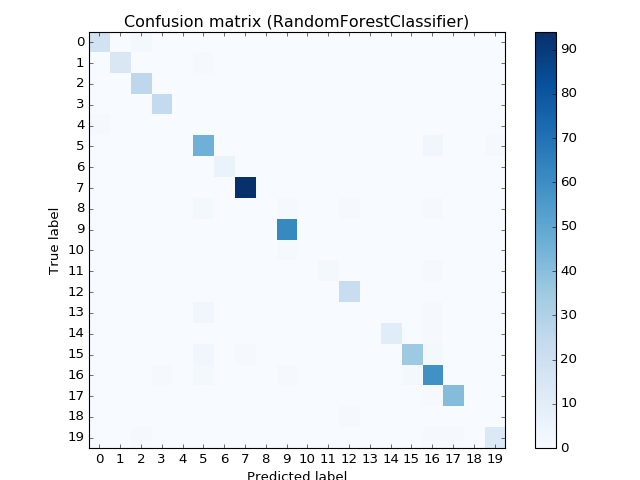

<IPython.core.display.Javascript object>


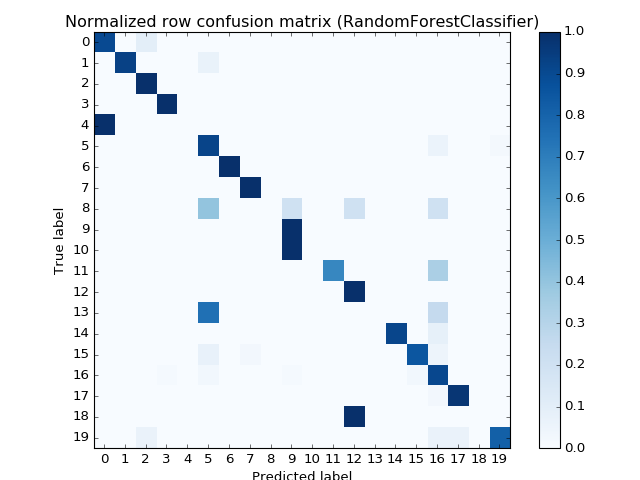

Some columns might have no predictions causing division by zero thus making normalization by column unattractive.


<IPython.core.display.Javascript object>


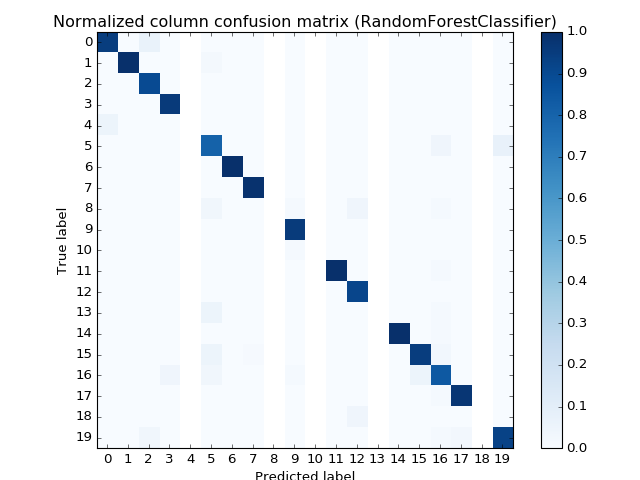

C:\Users\off99555\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: invalid value encountered in divide


In [29]:
for clf, y_pred in zip(clfs, y_preds):
    cm = confusion_matrix(y_true, y_pred)
#     print 'Confusion matrix, without normalization'
    print cm
    plt.figure()
    plot_confusion_matrix(cm, model_name=type(clf).__name__)

    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print 'Normalized confusion matrix (Had to scale by 99 not 100 because the matrix will be too big and wrap lines)'
#     print (cm_normalized * 99).astype('int')
    plt.figure()
    plot_confusion_matrix(cm_normalized, title='Normalized row confusion matrix', model_name=type(clf).__name__)
    
    print 'Some columns might have no predictions causing division by zero thus making normalization by column unattractive.'
    plt.figure()
    cm_normalized_col = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
    plot_confusion_matrix(cm_normalized_col, title='Normalized column confusion matrix', model_name=type(clf).__name__)

plt.show()

### Classification Report
Show scoring like precision, recall, f1 and their average for each label

In [30]:
for y_pred, clf in zip(y_preds, clfs):
    print type(clf).__name__
    print classification_report(y_true, y_pred, target_names=None)

RandomForestClassifier
             precision    recall  f1-score   support

          0       0.95      0.90      0.92        20
          1       1.00      0.93      0.97        15
          2       0.90      1.00      0.95        26
          3       0.96      1.00      0.98        24
          4       0.00      0.00      0.00         1
          5       0.81      0.92      0.86        50
          6       1.00      1.00      1.00         6
          7       0.99      1.00      0.99        94
          8       0.00      0.00      0.00         5
          9       0.95      1.00      0.98        62
         10       0.00      0.00      0.00         1
         11       1.00      0.67      0.80         3
         12       0.92      1.00      0.96        22
         13       0.00      0.00      0.00         4
         14       1.00      0.92      0.96        12
         15       0.95      0.85      0.90        41
         16       0.84      0.91      0.87        65
         17       0.98

C:\Users\off99555\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Learning Curves
Watch the performance of our chosen model as we increase the training size and check if it has variance or bias or somewhere in between

In [31]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 6)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-Score Weighted of CVs")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring='f1_weighted',
                                                            n_jobs=n_jobs, train_sizes=train_sizes, verbose=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print 'Train scores mean:', train_scores_mean
    print 'Test scores mean:', test_scores_mean
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="%d-Fold Cross-validation score" % cv)

    plt.legend(loc="best")
    return plt

RandomForestClassifier


<IPython.core.display.Javascript object>


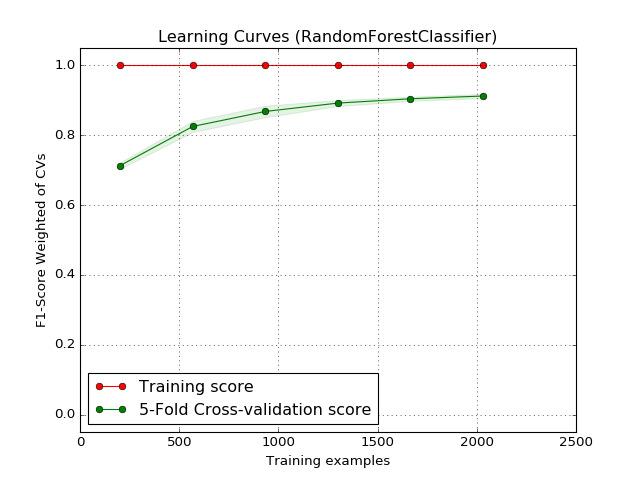

C:\Users\off99555\Anaconda2\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


[learning_curve] Training set sizes: [ 203  568  934 1299 1665 2031]
Train scores mean: [ 1.  1.  1.  1.  1.  1.]
Test scores mean: [ 0.71336642  0.82522681  0.8682374   0.89217375  0.90448779  0.91245992]
Wall time: 16min 56s
Wall time: 16min 56s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 16.9min finished


In [32]:
%%time
# cv = ShuffleSplit(X_train_selected.shape[0], n_iter=5, test_size=0.2, random_state=42)
X = vstack((X_train_final, X_test_final))
y = np.concatenate((y_train, y_test))
for clf in clfs:
    print type(clf).__name__
    title = 'Learning Curves (%s)' % type(clf).__name__
    %time plot_learning_curve(clf, title, X, y, ylim=(-0.05, 1.05), cv=5, n_jobs=1)
plt.show()

## Saving models

In [38]:
delattr(counter, 'stop_words_') # remove large unnecessary attribute

In [46]:
%%time
import joblib
filename = 'models_persistence/pickle_models'
files = joblib.dump((pretty_trim, counter, tfidf, rfe, clfs), filename)
print 'Total files:', len(files)

Total files: 410
Wall time: 10.9 s


In [45]:
%%time
filename = 'models_persistence/final_dataset'
files = joblib.dump((X_train_final, y_train, X_test_final, y_test), filename)
print 'Total files:', len(files)

Total files: 9
Wall time: 359 ms
